# Moment-Curvature Verification
This notebook is a verification report for the calculation of the Moment-Curvature with "mkappa.py" of the [bmcs_cross_section](https://github.com/bmcs-group/bmcs_cross_section) package.


In [1]:
%matplotlib widget

In [3]:
from bmcs_cross_section.api import MKappa
from bmcs_cross_section.api import ReinfLayer, BarLayer
from bmcs_utils.api import InteractiveWindow
from bmcs_cross_section.cs_design.cs_shape import TShape
import matplotlib.pyplot as plt
from os.path import join
import numpy as np
import sympy as sp
import pandas as pd
import bmcs_utils.api as bu
sp.init_printing()

In [4]:
def plot(mc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    mc.plot_mk_and_stress_profile(ax1, ax2)
    plt.show()

def plot_mk_ver(mc, ver_data, test_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    mc.plot_mk_and_stress_profile(ax1, ax2)
    k = ver_data[0]
    m = ver_data[1]
    ax1.plot(k, m, c= 'red', label= 'Experiment by ' + test_name)
    ax1.legend()  
    return fig

    
def plot_mk_ver_on_ax(ax, name, mc, ver_data):
    m_sim, k_sim = mc.get_mk()
    k_exp = ver_data[0]
    m_exp = ver_data[1]
    ax.plot(k_sim, m_sim, c= 'black', label= 'Sim - ' + name)
    ax.plot(k_exp, m_exp, c= 'red', label= 'Exp - ' + name, linestyle='--')
    ax.set_xlabel('Krümmung [mm$^{-1}$]')
    ax.set_ylabel('Moment [kNm]')
    ax.legend()

## 1. Checking the model with its default parameters

In [4]:
mc = MKappa()
bl1 = ReinfLayer(name='steel 1', z=10, A=100, count=2 )
csl = mc.cross_section_layout
csl.add_layer(bl1)

In [5]:
mc.interact()

eta 0.004999999999999999
M - k recalculated


## 2. Verification with experimental results

Verification with experimental results from multiple papers using the summarized parameters in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

### Verification with Rectangluar cross sections
In the following verifications, the parameters will be taken from the parameters summary in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the MKappa model

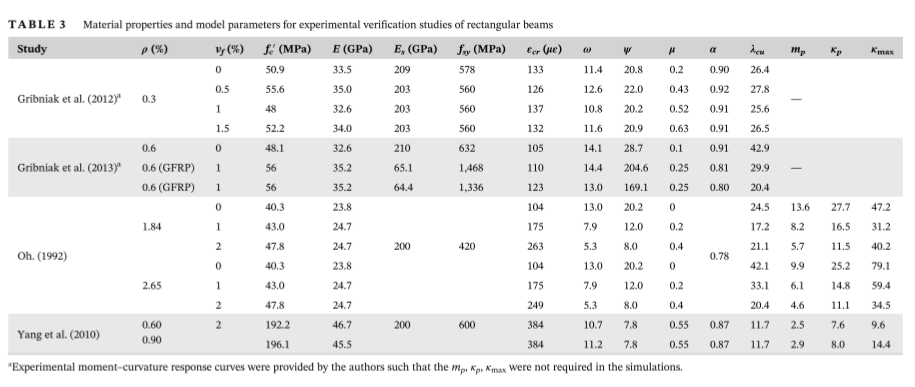

In [6]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape_.B=b
    mc.cross_section_shape_.H=h
    
    mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E, # SUPPOSED equal to E_cc
        mu=mu,
        eps_cr=eps_cr,
        eps_cy=omega * (-eps_cr),
        eps_cu=lambda_cu * (-eps_cr),
        eps_tu=beta_tu * eps_cr
    )
    
    bl1 = ReinfLayer(name='layer')
    mc.cross_section_layout.add_layer(bl1)
    bl1.trait_set(z=h * (1 - alpha), A=rho * b * alpha * h)
    bl1.matmod_.trait_set(E_s=E_s, f_sy=f_sy)

#### 1. Verification with Gribniak et al. (2012), https://doi.org/10.1016/j.engstruct.2012.04.032, Steel reinforcement
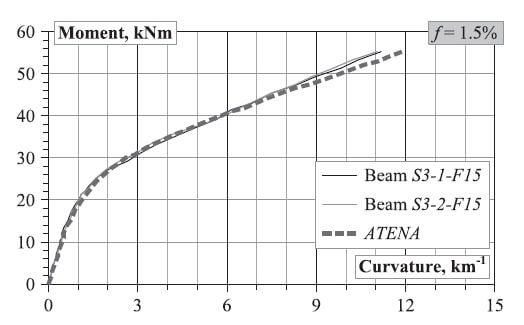

In [7]:
_ , (ax_gri) = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
# Beam S3-1-F15
excel_file = join('verification_data', 'Gribniak2012', 'fig_6.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['S3_1_F15_Curvature']
m= data['S3_1_F15_Moment']
ver_data = [k, m]

mc = MKappa(low_kappa = 0, high_kappa = 12e-6)
mc.cs_design.matrix='piecewise linear'
mc.cs_design.matrix_.trait_set(
        E_cc=34000,
        E_ct=34000,
        mu=0.7,
        eps_cr=0.000132,
        eps_cy=0.00175,
        eps_cu=0.0035,
        eps_tu=0.0023
    )

d = 272
b = 300
h = 279
a_2 = 26
mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h
bl1 = ReinfLayer(name='layer1', z=h-d, A=235)
bl2 = ReinfLayer(name='layer2', z=h-a_2, A=56)
bl1.matmod_.trait_set(E_s=202800, f_sy=560)
bl2.matmod_.trait_set(E_s=202800, f_sy=560)
mc.cross_section_layout.add_layer(bl1)
mc.cross_section_layout.add_layer(bl2)

# plot_mk_ver(mc, ver_data, 'Gribniak et al. (2012)')
plot_mk_ver_on_ax(ax_gri, 'V$_\mathrm{f}$ = 1.5%', mc, ver_data)

M - k recalculated


In [9]:
# Beam S3_1_F05
excel_file = join('./verification_data/Gribniak2012/', 'fig_6.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['S3_1_F05_Curvature']
m= data['S3_1_F05_Moment']
ver_data = [k, m]

mc = MKappa(low_kappa = 0, high_kappa = 12e-6)
mc.cs_design.matrix='piecewise linear'
mc.cs_design.matrix_.trait_set(
        E_cc=35000,
        E_ct=35000,
        mu=0.42,
        eps_cr=0.000132,
        eps_cy=0.00175,
        eps_cu=0.0035,
        eps_tu=0.0025
    )

d = 278
b = 278
h = 302
a_2 = 29
mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h
bl1 = ReinfLayer(name='layer1', z=h-d, A=235)
bl2 = ReinfLayer(name='layer2', z=h-a_2, A=56)
bl1.matmod_.trait_set(E_s=202800, f_sy=560)
bl2.matmod_.trait_set(E_s=202800, f_sy=560)
mc.cross_section_layout.add_layer(bl1)
mc.cross_section_layout.add_layer(bl2)

# plot_mk_ver(mc, ver_data, 'Gribniak et al. (2012)')
plot_mk_ver_on_ax(ax_gri, 'V$_\mathrm{f}$ = 0.5%', mc, ver_data)

M - k recalculated


#### 2. Verification with Yang et al. (2010), http://dx.doi.org/10.1016/j.engstruct.2010.07.017, Steel reinforcement
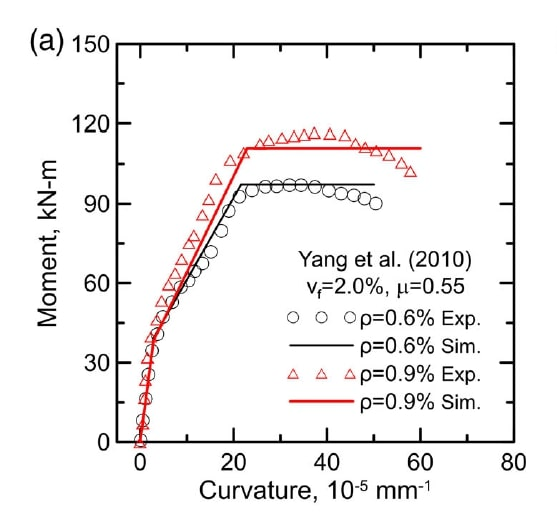

In [10]:
_ , (ax_yang) = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
# R12-1,2 (rho = 0.6%)

excel_file = join('./verification_data/yang2010', 'fig_18', 'yang2010.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['beam_R12_2_Curvature']
m= data['beam_R12_2_Moment']
ver_data = [k, m]

mc = MKappa(n_m=100, n_kappa = 100)
mc.kappa_slider = 0.00001
mc.low_kappa = 0
mc.high_kappa = 0.00005
map_and_assign_params_for_rectangular_section(mc,
    beta_tu = 20, # Not sure where this is from, all other values match Mobasher
        b = 180, # 180 is the original, Saeed used b = 190
        h = 270,
        E = 46418, # according to Yang paper, according to Mobasher 46700
        E_s = 200000,
        f_sy = 600,
        eps_cr = 0.000384,
        rho = 0.006,
        v_f = 0.02,
        omega = 10.7,
        psi = 7.8,
        mu = 0.55,
        alpha = 0.87,
        lambda_cu = 11.7)

# plot_mk_ver(mc, ver_data, 'Yang et al. (2010)')
plot_mk_ver_on_ax(ax_yang, 'rho = 0.6%', mc, ver_data)

M - k recalculated


In [12]:
# R13-2 (rho = 0.9%)

excel_file = join('./verification_data/yang2010', 'fig_18', 'yang2010.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['beam_R13_2_Curvature']
m= data['beam_R13_2_Moment']
ver_data = [k, m]

mc = MKappa(n_m=100, n_kappa = 100)
mc.kappa_slider = 0.00001
mc.low_kappa = 0
mc.high_kappa = 0.00005
map_and_assign_params_for_rectangular_section(mc,
    beta_tu = 24, # Not sure where this is from, all other values match Mobasher
        b = 180,
        h = 270,
        E = 46680,  # according to Yang paper, according to Mobasher 45500
        E_s = 200000,
        f_sy = 600,
        eps_cr = 0.000384,
        rho = 0.009,
        v_f = 0.02,
        omega = 11.2,
        psi = 7.8,
        mu = 0.58,
        alpha = 0.87,
        lambda_cu = 11.7)

# plot_mk_ver(mc, ver_data, 'Yang et al. (2010)')
plot_mk_ver_on_ax(ax_yang, 'rho = 0.9%', mc, ver_data)

M - k recalculated


#### 3. Verification with Von der Heid. et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

In [5]:
# HB-SU-0-1 to HB-SU-0-6
excel_file = join('./verification_data/Von_der_Heid_2020', 'fig.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k_data= [data['HB-SU-0-1_Curvature'], data['HB-SU-0-2_Curvature'], 
         data['HB-SU-0-3_Curvature'], data['HB-SU-0-4_Curvature'], 
         data['HB-SU-0-5_Curvature'], data['HB-SU-0-6_Curvature']]

m_data= [data['HB-SU-0-1_Moment'], data['HB-SU-0-2_Moment'],
         data['HB-SU-0-3_Moment'], data['HB-SU-0-4_Moment'],
         data['HB-SU-0-5_Moment'], data['HB-SU-0-6_Moment']]
ver_data = [k_data, m_data]
# E = 35786.7
E = 39500

# from bending test from σ_c,Riss
# eps_cr = 0.000163
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(low_kappa = 0, high_kappa = 0.0007, n_kappa = 100)
mc.cs_design.matrix='piecewise linear'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=eps_cr,
        eps_cy=72/E, # 0.0019 from EC2 for C60
        eps_cu=(72/E)*2, # 0.0029 from EC2 for C60
        eps_tu=9.02/E,
        mu=0.0,
    )

mc.cross_section_shape_.B = 90
mc.cross_section_shape_.H = 30
bl1 = ReinfLayer(name='layer1', z=8, A=2*3.62, matmod='carbon')
bl2 = ReinfLayer(name='layer2', z=22, A=2*3.62, matmod='carbon')
bl1.matmod_.trait_set(E=240000, f_t=2712)
bl2.matmod_.trait_set(E=240000, f_t=2712)
mc.cross_section_layout.add_layer(bl1)
mc.cross_section_layout.add_layer(bl2)

fig, (ax1) = plt.subplots()
mc.plot_mk(ax1)

for k, m in zip(k_data, m_data):
    ax1.plot(k, m, label= 'Exp', alpha=0.2)
    
ax1.legend()
# plot_mk_ver(mc, [k_data, m_data], 'Heid. et al. (2020)')

mc.interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

M - k recalculated
eta 0.00014285714285714284


#### 3. Verification with Rempel et al. (2020), https://doi.org/10.1002/best.201900086, AR-Glas reinforcement
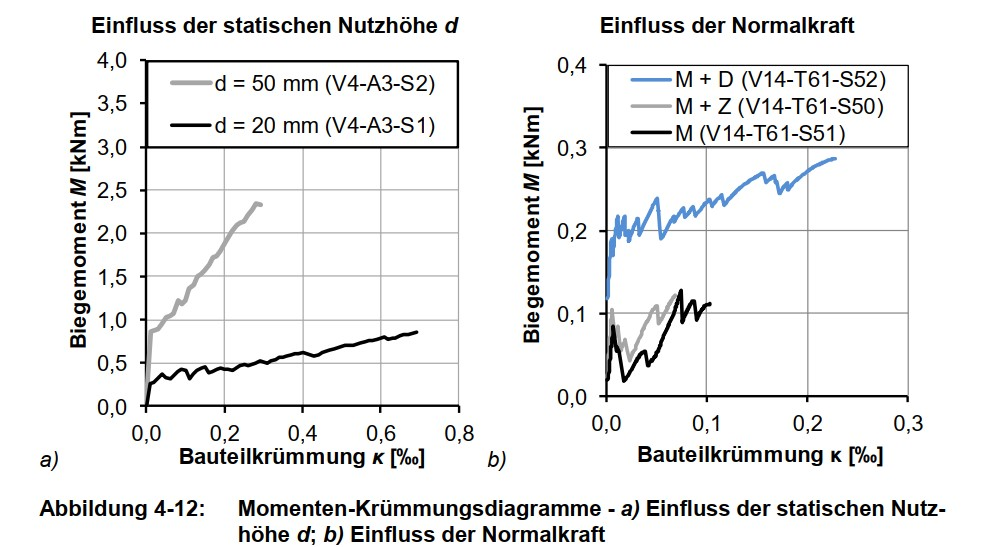

In [15]:
# a)
excel_file = join('./verification_data/Rem20/Abbildung_4-12', 'rem18_4-12-a.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['V4-A3-S1_k'] * 1e-3; m= data['V4-A3-S1_m']; ver_data = [k, m]; plt.plot(k, m, label='V4-A3-S1')
k1= data['V4-A3-S2_k'] * 1e-3; m1= data['V4-A3-S2_m']; ver_data1 = [k1, m1]; plt.plot(k1, m1, label='V4-A3-S2')
plt.legend()
plt.ylabel('Moment [kNm]')
plt.xlabel('Curvature [mm$^{-1}$]');


# V4-A3-S1
mc = MKappa(n_m=100, n_kappa = 100)
mc.kappa_slider = 0.000001
mc.low_kappa = 0
mc.high_kappa = 50e-6
mc.reinforcement_type = ReinforcementType.CARBON

map_and_assign_params_for_rectangular_section(mc,
    beta_tu = 190,  # SUPPOSED because it's missing
        b = 300,
        h = 40,
        E = 34000 ,
        E_s = 74618, # Kett: 70843
        f_sy = 1599, #Kett:1590
        eps_cr = 0.0214, # Ket: 0.0224
        rho = 0.003,
        v_f = 0.015,
        omega = 11.6,
        psi = 20.9,
        mu = 0.63,
        alpha = 0.91,
        lambda_cu = 26.5)

plot_mk_ver(mc, ver_data1)

TypeError: plot_mk_ver() missing 1 required positional argument: 'test_name'

In [15]:
# b)
excel_file = join('./verification_data/Rem20/Abbildung_4-12', 'rem18_4-12-b.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['V14-T61-S51_k'] * 1e-3; m= data['V14-T61-S51_m']; ver_data = [k, m]; plt.plot(k, m, label='V14-T61-S51')
k1= data['V14-T61-S50_k'] * 1e-3; m1= data['V14-T61-S50_m']; ver_data1 = [k1, m1]; plt.plot(k1, m1, label='V14-T61-S50')
k2= data['V14-T61-S52_k'] * 1e-3; m2= data['V14-T61-S52_m']; ver_data2 = [k2, m2]; plt.plot(k2, m2, label='V14-T61-S52')
plt.legend()
plt.ylabel('Moment [kNm]')
plt.xlabel('Curvature [mm$^{-1}$]')


# V14-T61-S52
mc = MKappa(n_m=100, n_kappa = 100)
mc.kappa_slider = 0.000001
mc.low_kappa = 0
mc.high_kappa = 5e-6

map_and_assign_params_for_rectangular_section(mc,
    beta_tu = 190,  # SUPPOSED because it's missing
        b = 300,
        h = 40,
        E = 34000,
        E_s = 74618, # Kett: 70843
        f_sy = 1599, #Kett:1590
        eps_cr = 0.0214, # Kett: 0.0224
        rho = 0.003,
        v_f = 0.015,
        omega = 11.6,
        psi = 20.9,
        mu = 0.63,
        alpha = 0.91,
        lambda_cu = 26.5)
plot_mk_ver(mc, ver_data2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Verification with T-sections
In the following verifications, the parameters will be taken from the parameters summary in Table 4 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the MKappa model

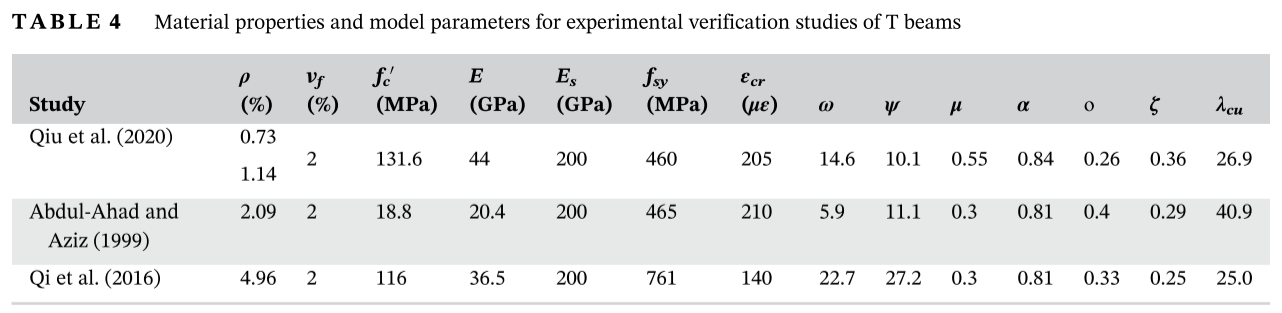

In [26]:
def map_and_assign_params_for_t_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu, o, zeta):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    t_shape = TShape(H = h, B_f = b, B_w = o*b, H_w = (1-zeta)*h)
    mc.cross_section_shape = t_shape
    
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr   
    mc.cross_section_layout.reinforcement = [Reinforcement(
        eps_sy=f_sy / E_s, # or eps_sy_j=psi * eps_cr,
        E=E_s,
        z=h * (1 - alpha),
        A= rho * t_shape.get_cs_area())]

#### 1. Verification with Qiu et al. (2020), https://doi.org/10.1186/s40069-019-0380-x, Steel reinforcement
![Qui_2020.jpg](attachment:Qui_2020.jpg)

In [27]:
_, (ax_qui) = plt.subplots()

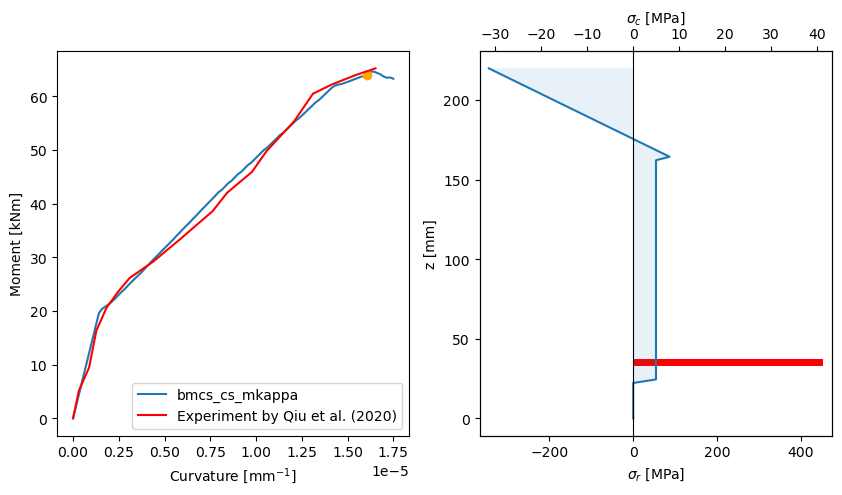

In [30]:
excel_file = join('./verification_data/yao20_yao_mobasher/table_4', 'qui20.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['B-S65-16_k'] * 1e-6
m= data['B-S65-16_m']
ver_data = [k, m]
plt.plot(k, m, label='B-S65-16')
k1= data['B-S65-20_k'] * 1e-6
m1= data['B-S65-20_m']
ver_data1 = [k1, m1]


# B-S65-16
mc = MKappa(n_m=100, n_kappa = 100)
mc.low_kappa = 0
mc.high_kappa = 0.0000175
mc.kappa_slider = 0.000016
map_and_assign_params_for_t_section(mc,
            beta_tu = 12,  
            b = 700,       
            h = 220,         
            E = 44000,
            E_s = 200000,
            f_sy = 460,
            eps_cr = 0.000205,
            rho = 0.0073, 
            v_f = 0.0,
            omega = 14.6,
            psi = 10.1,
            mu = 0.55,
            alpha = 0.84,
            o = 0.26,
            zeta = 0.36,
            lambda_cu = 26.9)

plot_mk_ver(mc, ver_data, 'Qiu et al. (2020)')
# plot_mk_ver_on_ax(ax_yang, '$\rho$ = 0.9%', mc, ver_data)

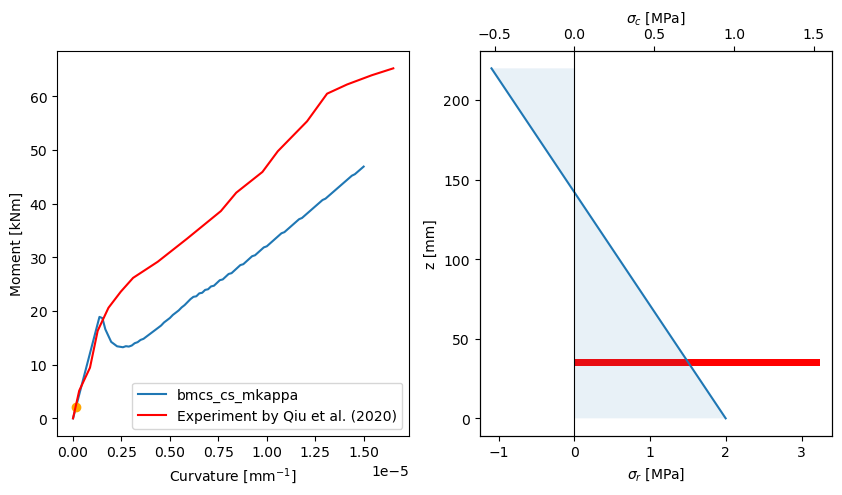

In [31]:
excel_file = join('./verification_data/yao20_yao_mobasher/table_4', 'qui20.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
k= data['B-S65-16_k'] * 1e-6; m= data['B-S65-16_m']; ver_data = [k, m]; plt.plot(k, m, label='B-S65-16')
k1= data['B-S65-20_k'] * 1e-6; m1= data['B-S65-20_m']; ver_data1 = [k1, m1]; plt.plot(k1, m1, label='B-S65-20')
plt.legend()
plt.ylabel('Moment [kNm]')
plt.xlabel('Curvature [mm$^{-1}$]')

# B-S65-16
mc = MKappa(n_m=100, n_kappa = 100)
mc.low_kappa = 0
mc.high_kappa = 0.000015
map_and_assign_params_for_t_section(mc,
            beta_tu = 5,  
            b = 700,       
            h = 220,         
            E = 44000,
            E_s = 200000,
            f_sy = 460,
            eps_cr = 0.000205,
            rho = 0.0073, 
            v_f = 0.0,
            omega = 14.6,
            psi = 10.1,
            mu = 0.00,
            alpha = 0.84,
            o = 0.26,
            zeta = 0.36,
            lambda_cu = 26.9)

plot_mk_ver(mc, ver_data, 'Qiu et al. (2020)')